In [ ]:
import pandas as pd

In [ ]:
df=pd.read_excel("Online Retail.xlsx")

In [ ]:
print(df.head())
print("______________________")
print(df.info())
print("_______________________")
print(df.describe())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
______________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  -

In [ ]:
print(df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [ ]:
df=df.dropna(subset=['Description'])
df=df.dropna(subset=['CustomerID'])

In [ ]:
#In order to check
print(df.isnull().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [ ]:
num_cols=df.select_dtypes(include='number').columns
(df[num_cols]<0).any()

,0
Quantity,True
UnitPrice,False
CustomerID,False


In [ ]:
df=df[df['Quantity']>0]
df=df[df['UnitPrice']>0]
df['TotalAmount']=df['Quantity']*df['UnitPrice']
print((df[num_cols]<=0).any())

Quantity      False
UnitPrice     False
CustomerID    False
dtype: bool


In [ ]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)


rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'                                      #
})


rfm.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency',
                    'TotalAmount': 'Monetary'}, inplace=True)

print("\nRFM Table (first 5 rows):")
print(rfm.head())


rfm['R_score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])


rfm['RFM_Segment'] = (rfm['R_score'].astype(str) +
                      rfm['F_score'].astype(str) +
                      rfm['M_score'].astype(str))
rfm['RFM_Score'] = rfm[['R_score','F_score','M_score']].astype(int).sum(axis=1)

print("\nRFM Segments (first 5 rows):")
print(rfm.head())


RFM Table (first 5 rows):
            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2          7   4310.00
12348.0          75          4   1797.24
12349.0          19          1   1757.55
12350.0         310          1    334.40

RFM Segments (first 5 rows):
            Recency  Frequency  Monetary R_score F_score M_score RFM_Segment  \
CustomerID                                                                     
12346.0         326          1  77183.60       1       1       4         114   
12347.0           2          7   4310.00       4       4       4         444   
12348.0          75          4   1797.24       2       3       4         234   
12349.0          19          1   1757.55       3       1       4         314   
12350.0         310          1    334.40       1       1       2         112   

            RFM_Score  
CustomerID             
12346.0             6  
12347.0            12  

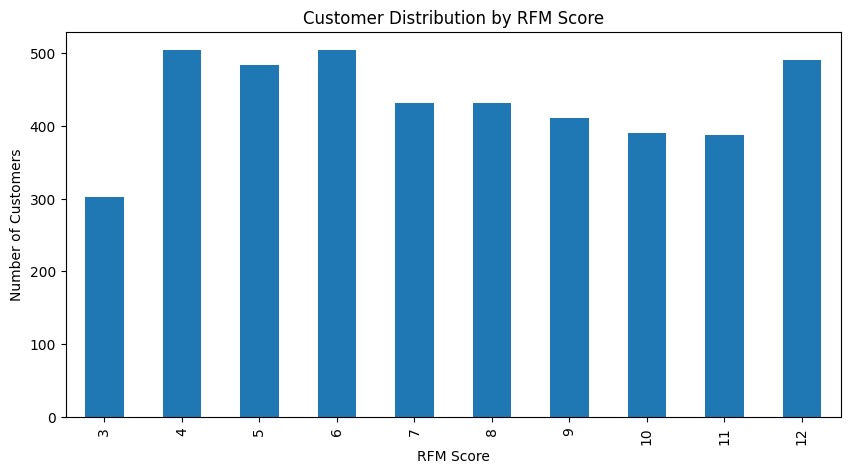

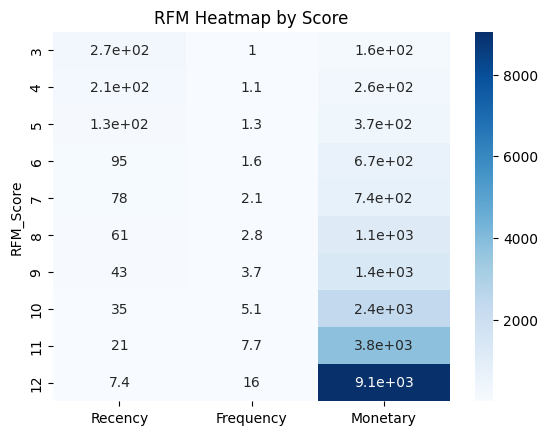

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

rfm['RFM_Score'] = rfm['RFM_Score'].astype(int)

rfm['RFM_Score'].value_counts().sort_index().plot(kind='bar', figsize=(10,5))
plt.title("Customer Distribution by RFM Score")
plt.xlabel("RFM Score")
plt.ylabel("Number of Customers")
plt.show()

rfm_agg = rfm.groupby('RFM_Score')[['Recency','Frequency','Monetary']].mean()

sns.heatmap(rfm_agg, annot=True, cmap="Blues")
plt.title("RFM Heatmap by Score")
plt.show()